In [8]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard
%matplotlib inline

# Mounting and Installation of Package: Only on Google Colab

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd /content/drive/My\ Drive/Colab\ Notebooks/adversarial_reisz

/content/drive/My Drive/Colab Notebooks/adversarial_reisz


In [5]:
!python setup.py develop

running develop
running egg_info
writing advreisz.egg-info/PKG-INFO
writing dependency_links to advreisz.egg-info/dependency_links.txt
writing top-level names to advreisz.egg-info/top_level.txt
writing manifest file 'advreisz.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.7/dist-packages/advreisz.egg-link (link to .)
Adding advreisz 0.0.1 to easy-install.pth file

Installed /content/drive/My Drive/Colab Notebooks/adversarial_reisz
Processing dependencies for advreisz==0.0.1
Finished processing dependencies for advreisz==0.0.1


# Library Imports

In [9]:
import numpy as np
import torch
from pathlib import Path
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy
import scipy.special
import advreisz
from advreisz.deepreisz import DeepReisz, AdvReisz

# Data Generation

In [10]:
def nonlin(x):
    # return 1.5 * (x[:, 1]**2)
    return scipy.special.expit(10 * x[:, 1])
    # return np.abs(x[:, 1])
    # return 1.5*scipy.special.expit(10 * x[:, 1]) - 1.5*scipy.special.expit(10 * x[:, 2])

def true_propensity(X):
    return .5 + .3 * nonlin(X)

def true_f(X):
    return X[:, 0] + nonlin(X)

def gen_data(n, p):
    X = np.random.uniform(-1, 1, size=(n, p))
    X[:, 0] = np.random.binomial(1, true_propensity(X))
    y = true_f(X) + np.random.normal(size=(n,))
    return X, y

np.random.seed(123)
n = 1000
p = 3
X, y = gen_data(n, p)
X_test, y_test = gen_data(n, p)

# Moment Definition

### ATE Moment

In [11]:
# Returns the moment for the ATE example, for each sample in x
def moment_fn(x, test_fn):
    if torch.is_tensor(x):
        with torch.no_grad():
            t1 = torch.cat([torch.ones((x.shape[0], 1)).to(device), x[:, 1:]], dim=1)
            t0 = torch.cat([torch.zeros((x.shape[0], 1)).to(device), x[:, 1:]], dim=1)
    else:
        t1 = np.hstack([np.ones((x.shape[0], 1)), x[:, 1:]])
        t0 = np.hstack([np.zeros((x.shape[0], 1)), x[:, 1:]])
    return test_fn(t1) - test_fn(t0)

def true_reisz(x, propensity=true_propensity):
    return (x[:, 0]==1) / propensity(x) - (x[:, 0]==0)/(1 - propensity(x))

### Policy Moment

In [ ]:
policy = lambda x: scipy.special.expit(10*x[:, 1]) if not torch.is_tensor(x) else torch.sigmoid(10 * x[:, 1])

def moment_fn(x, test_fn):
    with torch.no_grad():
        if torch.is_tensor(x):
            t1 = torch.cat([torch.ones((x.shape[0], 1)).to(device), x[:, 1:]], dim=1)
            t0 = torch.cat([torch.zeros((x.shape[0], 1)).to(device), x[:, 1:]], dim=1)
        else:
            t1 = np.hstack([np.ones((x.shape[0], 1)), x[:, 1:]])
            t0 = np.hstack([np.zeros((x.shape[0], 1)), x[:, 1:]])
        p1 = policy(x)
    out1 = test_fn(t1)
    out0 = test_fn(t0)
    if len(out1.shape) > 1:
        p1 = p1.reshape(-1, 1)
    return out1 * p1 + out0 * (1 - p1) 

def true_reisz(x, propensity=true_propensity):
    p1 = policy(x)
    prop1 = propensity(x)
    return p1 * (x[:, 0]==1) / prop1 + (1 - p1) * (x[:, 0]==0)/(1 - prop1)

### X-Transformation Moment

In [ ]:
trans = lambda x: (1 + x)**(1/2)/2**(1/2)
invtrans = lambda u: 2 * (u**2) - 1
grad_invtrans = lambda u: 4 * u

def moment_fn(x, test_fn):
    with torch.no_grad():
        if torch.is_tensor(x):
            tx = torch.cat([x[:, [0]], trans(x[:, [1]]), x[:, 2:]], dim=1)
        else:
            tx =  np.hstack([x[:, [0]], trans(x[:, [1]]), x[:, 2:]])
    return test_fn(tx) - test_fn(x)

def true_reisz(x, propensity=true_propensity):
    invtx = np.hstack([x[:, [0]], invtrans(x[:, [1]]), x[:, 2:]])
    out0 = np.clip(propensity(invtx) * grad_invtrans(x[:, 1]) / propensity(x), 0, np.inf)
    out1 = np.clip((1 - propensity(invtx)) * grad_invtrans(x[:, 1]) / (1 - propensity(x)), 0, np.inf)
    return out0 * x[:, 0] + out1 * (1 - x[:, 0]) - 1

# Adversarial Reisz Estimator for ATE Moment

In [9]:
drop_prob = 0. # dropout prob of dropout layers throughout notebook
n_hidden = 100  # width of hidden layers throughout notebook

# Training params
learner_lr = 1e-4
adversary_lr = 1e-4
learner_l2 = 1e-3
adversary_l2 = 1e-3
n_epochs = 1000
preprocess_epochs = 200 # how many epochs to use to create an approximation to the max objective for earlystopping
earlystop_rounds = 40 # how many epochs to wait for an out-of-sample improvement
store_test_every = 20 # after how many training iterations to store a test function during preprocessing
bs = 100
device = torch.cuda.current_device() if torch.cuda.is_available() else None

# Returns a deep model for the reisz representer
def _get_learner(n_t, n_hidden, p):
    return nn.Sequential(nn.Dropout(p=p), nn.Linear(n_t, n_hidden), nn.LeakyReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, n_hidden), nn.LeakyReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, 1))

# Returns a deep model for the test functions
def _get_adversary(n_z, n_hidden, p):
    return nn.Sequential(nn.Dropout(p=p), nn.Linear(n_z, n_hidden), nn.ReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, n_hidden), nn.ReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, 1))

print("GPU:", torch.cuda.is_available())

GPU: True


In [10]:
torch.cuda.empty_cache()
Xt = torch.Tensor(X).to(device)
Xt_test = torch.Tensor(X_test).to(device)
At_test = torch.Tensor(true_reisz(X_test).reshape(-1, 1)).to(device)
learner = _get_learner(Xt.shape[1], n_hidden, drop_prob)
adversary = _get_adversary(Xt.shape[1], n_hidden, drop_prob)
agmm = AdvReisz(learner, adversary, moment_fn)

def violation_fn(x, learner, adversary):
    return moment_fn(x, adversary) - learner(x) * adversary(x)

def logger(estimator, learner, adversary, epoch, writer):
    writer.add_histogram('learner', learner[-1].weight, epoch)
    writer.add_histogram('adversary', adversary[-1].weight, epoch)
    writer.add_scalar('moment', torch.mean(violation_fn(Xt, learner, adversary)), epoch)
    writer.add_scalar('moment_val', torch.mean(violation_fn(Xt_test, learner, adversary)), epoch)
    writer.add_scalar('true_mse_val', torch.mean((At_test - learner(Xt_test))**2)/4, epoch)
    if hasattr(estimator, 'curr_eval'):
        writer.add_scalar('approx_violation_val', estimator.curr_eval, epoch)

In [21]:
agmm.fit(Xt, Xval=Xt_test, preprocess_epochs=preprocess_epochs,
         earlystop_rounds=earlystop_rounds,
         store_test_every=store_test_every,
         learner_lr=learner_lr, adversary_lr=adversary_lr,
         learner_l2=learner_l2, adversary_l2=adversary_l2,
         n_epochs=n_epochs, bs=bs,
         logger=logger, model_dir=str(Path.home()), device=device, verbose=1)

Epoch #0
Epoch #1
Epoch #2
Epoch #3
Epoch #4
Epoch #5
Epoch #6
Epoch #7
Epoch #8
Epoch #9
Epoch #10
Epoch #11
Epoch #12
Epoch #13
Epoch #14
Epoch #15
Epoch #16
Epoch #17
Epoch #18
Epoch #19
Epoch #20
Epoch #21
Epoch #22
Epoch #23
Epoch #24
Epoch #25
Epoch #26
Epoch #27
Epoch #28
Epoch #29
Epoch #30
Epoch #31
Epoch #32
Epoch #33
Epoch #34
Epoch #35
Epoch #36
Epoch #37
Epoch #38
Epoch #39
Epoch #40
Epoch #41
Epoch #42
Epoch #43
Epoch #44
Epoch #45
Epoch #46
Epoch #47
Epoch #48
Epoch #49
Epoch #50
Epoch #51
Epoch #52
Epoch #53
Epoch #54
Epoch #55
Epoch #56
Epoch #57
Epoch #58
Epoch #59
Epoch #60
Epoch #61
Epoch #62
Epoch #63
Epoch #64
Epoch #65
Epoch #66
Epoch #67
Epoch #68
Epoch #69
Epoch #70
Epoch #71
Epoch #72
Epoch #73
Epoch #74
Epoch #75
Epoch #76
Epoch #77
Epoch #78
Epoch #79
Epoch #80
Epoch #81
Epoch #82
Epoch #83
Epoch #84
Epoch #85
Epoch #86
Epoch #87
Epoch #88
Epoch #89
Epoch #90
Epoch #91
Epoch #92
Epoch #93
Epoch #94
Epoch #95
Epoch #96
Epoch #97
Epoch #98
Epoch #99
Epoch #100

# Evaluation of Learned Reisz Representer

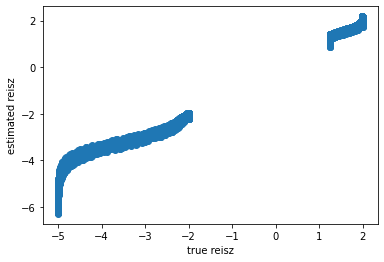

In [23]:
plt.figure()
model = 'earlystop'
plt.scatter(true_reisz(X_test), agmm.predict(torch.Tensor(X_test).to(device), model=model))
plt.xlabel('true reisz')
plt.ylabel('estimated reisz')
plt.show()

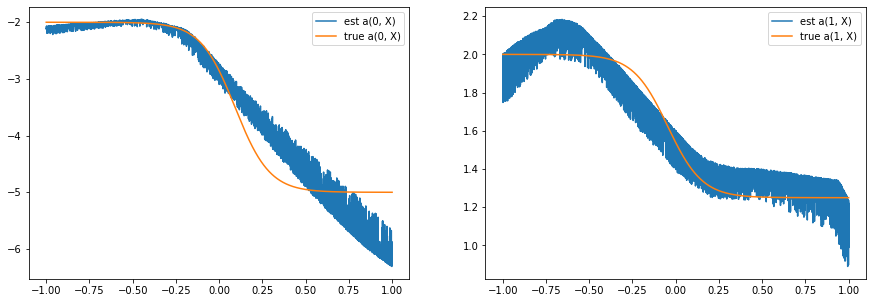

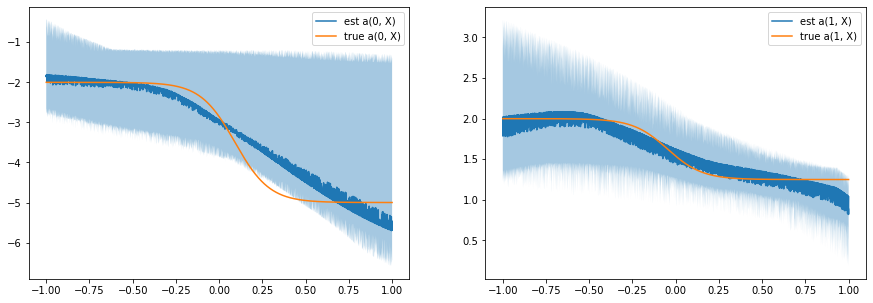

In [24]:
for model in ['earlystop', 'avg']:
    plt.figure(figsize=(15, 5))
    error = true_reisz(X_test) - agmm.predict(torch.Tensor(X_test).to(device), model=model)
    plt.title("RMSE: {:.3f}, MAE: {:.3f}".format(np.sqrt(np.mean(error**2)), np.mean(np.abs(error))))
    for t in [0, 1]:
        plt.subplot(1, 2, t + 1)
        treated = (X_test[:, 0]==t)
        Xtreated = X_test[treated].copy()
        Xtreated[:, 1] = np.linspace(-1, 1, Xtreated.shape[0])
        if model == 'avg':
            point, lb, ub = agmm.predict(torch.Tensor(Xtreated).to(device), model=model, alpha=.05, burn_in=0)
            plt.plot(Xtreated[:, 1], point, label='est a({}, X)'.format(t))
            plt.fill_between(Xtreated[:, 1], lb, ub, alpha=.4)
        else:
            point = agmm.predict(torch.Tensor(Xtreated).to(device), model=model)
            plt.plot(Xtreated[:, 1], point, label='est a({}, X)'.format(t))
        plt.plot(Xtreated[:, 1], true_reisz(Xtreated), label='true a({}, X)'.format(t))
        plt.legend()
    plt.show()

In [ ]:
%tensorboard --logdir=runs

# Debiasing ATE

Applying the learned Reisz representer in order to debias a preliminary regression based model of the ATE

In [19]:
def mean_ci(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [32]:
from sklearn.linear_model import LassoCV, Lasso, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

est = Pipeline([('p', PolynomialFeatures(degree=1)), ('l', Lasso(alpha=.1))]).fit(X, y)
propensity = Pipeline([('p', PolynomialFeatures(degree=3)), ('l', LogisticRegressionCV())]).fit(X[:, 1:], X[:, 0])

In [33]:
a_test = agmm.predict(Xt_test, model='earlystop')
invp_test = true_reisz(X_test, lambda x: propensity.predict_proba(x[:, 1:])[:, 1])
true_ate = np.mean(moment_fn(X_test, true_f))
naive_ate = np.mean(y_test[X_test[:, 0]==1]) - np.mean(y_test[X_test[:, 0]==0])
biased_ate = np.mean(moment_fn(X_test, est.predict))
ips_ate = np.mean(invp_test * y_test)
reisz_ate = np.mean(a_test * y_test)
dr_ate = biased_ate + np.mean(invp_test * (y_test - est.predict(X_test)))
dr_reisz_ate, dr_reisz_low, dr_reisz_up = mean_ci(moment_fn(X_test, est.predict) + a_test * (y_test - est.predict(X_test)))

In [34]:
print("True ATE: {:.3f}".format(true_ate))
print("Mean of Treated - Mean of Untreated: {:.3f}".format(naive_ate))
print("Lasso Regression based Estimate: {:.3f}".format(biased_ate))
print("IPS estimate with explicit propensity based reisz estimate (i.e. mean(a(X) Y)): {:.3f}".format(ips_ate))
print("IPS estimate with adversarial reisz: {:.3f}".format(reisz_ate))
print("DR estimate with explict propensity based reisz estimate: {:.3f}".format(dr_ate))
print("DR estimate with adversarial reisz: {:.3f} ({:.3f}, {:.3f})".format(dr_reisz_ate, dr_reisz_low, dr_reisz_up))

True ATE: 1.000
Mean of Treated - Mean of Untreated: 1.296
Lasso Regression based Estimate: 0.633
IPS estimate with explicit propensity based reisz estimate (i.e. mean(a(X) Y)): 1.040
IPS estimate with adversarial reisz: 1.074
DR estimate with explict propensity based reisz estimate: 1.023
DR estimate with adversarial reisz: 1.029 (0.984, 1.073)


In [35]:
dr_reisz_ate = []
reisz_ate = []
biased_ate = []
dr_reisz_cov = []
reisz_cov = []
for exp in range(1000):
    Xboot, yboot = gen_data(n, p)
    aboot = agmm.predict(Xboot, model='earlystop')
    drm, drl, dru = mean_ci(moment_fn(Xboot, est.predict) + aboot * (yboot - est.predict(Xboot)))
    rm, rl, ru = mean_ci(aboot * yboot)
    dr_reisz_ate.append(drm)
    reisz_ate.append(rm)
    dr_reisz_cov.append((true_ate <= dru) & (true_ate >= drl))
    reisz_cov.append((true_ate <= ru) & (true_ate >= rl))

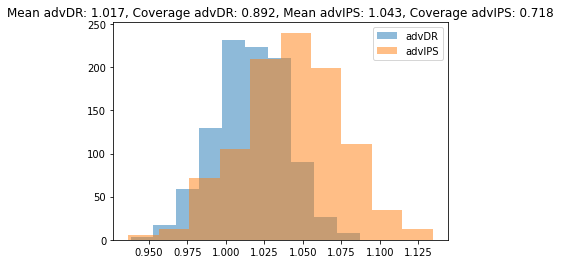

In [36]:
plt.title("Mean advDR: {:.3f}, Coverage advDR: {:.3f}, "
          "Mean advIPS: {:.3f}, Coverage advIPS: {:.3f}".format(np.mean(dr_reisz_ate),
                                                               np.mean(dr_reisz_cov),
                                                               np.mean(reisz_ate),
                                                               np.mean(reisz_cov)))
plt.hist(np.array(dr_reisz_ate), alpha=.5, label='advDR')
plt.hist(np.array(reisz_ate), alpha=.5, label='advIPS')
plt.legend()
plt.show()

In [71]:
import pandas as pd

df = pd.read_csv('rahul/sim_2.csv', index_col=0)
y = df['Y'].values
X = df[['D'] + [f'X{i}' for i in np.arange(1, 11)]].values

In [72]:
n_samples = 500
X, y = X[:n_samples], y[:n_samples]

In [73]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=.2, random_state=123)

In [74]:
torch.cuda.empty_cache()
Xt = torch.Tensor(Xtrain).to(device)
Xt_test = torch.Tensor(Xtest).to(device)
At_test = torch.Tensor(true_reisz(Xtest).reshape(-1, 1)).to(device)

In [75]:
learner = _get_learner(Xt.shape[1], n_hidden, drop_prob)
adversary = _get_adversary(Xt.shape[1], n_hidden, drop_prob)
agmm = AdvReisz(learner, adversary, moment_fn)
agmm.fit(Xt, Xval=Xt_test, preprocess_epochs=preprocess_epochs,
         earlystop_rounds=earlystop_rounds,
         store_test_every=store_test_every,
         learner_lr=learner_lr, adversary_lr=adversary_lr,
         learner_l2=learner_l2, adversary_l2=adversary_l2,
         n_epochs=n_epochs, bs=bs,
         logger=None, model_dir=str(Path.home()), device=device, verbose=0)

In [76]:
from sklearn.linear_model import LassoCV, Lasso, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

a_test = agmm.predict(X, model='avg')
est = Pipeline([('p', PolynomialFeatures(degree=1)), ('l', Lasso(alpha=.1))]).fit(X, y)
dr_reisz_ate, dr_reisz_low, dr_reisz_up = mean_ci(moment_fn(X, est.predict) + a_test * (y - est.predict(X)))

In [77]:
dr_reisz_ate, dr_reisz_low, dr_reisz_up

(2.1425451807510534, 1.9658299535538573, 2.3192604079482493)

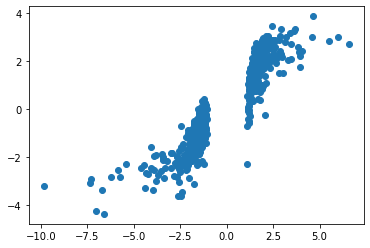

In [78]:
plt.scatter(df['rr'][:n_samples], a_test[:n_samples])
plt.show()

In [70]:
drop_prob = 0. # dropout prob of dropout layers throughout notebook
n_hidden = 100  # width of hidden layers throughout notebook

# Training params
learner_lr = 1e-4
adversary_lr = 1e-4
learner_l2 = 6e-5
adversary_l2 = 1e-5
n_epochs = 1000
preprocess_epochs = 200 # how many epochs to use to create an approximation to the max objective for earlystopping
earlystop_rounds = 100 # how many epochs to wait for an out-of-sample improvement
store_test_every = 20 # after how many training iterations to store a test function during preprocessing
bs = 100
device = torch.cuda.current_device() if torch.cuda.is_available() else None

# Returns a deep model for the reisz representer
def _get_learner(n_t, n_hidden, p):
    return nn.Sequential(nn.Dropout(p=p), nn.Linear(n_t, n_hidden), nn.LeakyReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, n_hidden), nn.LeakyReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, 1))

# Returns a deep model for the test functions
def _get_adversary(n_z, n_hidden, p):
    return nn.Sequential(nn.Dropout(p=p), nn.Linear(n_z, n_hidden), nn.ReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, n_hidden), nn.ReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, 1))

print("GPU:", torch.cuda.is_available())

GPU: True


In [31]:
import pandas as pd
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, Lasso, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def exp(it):
    print(it)
    df = pd.read_csv(f'rahul/sim_{it}.csv', index_col=0)
    y = df['Y'].values
    X = df[['D'] + [f'X{i}' for i in np.arange(1, 11)]].values
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=.2, random_state=123)

    torch.cuda.empty_cache()
    Xt = torch.Tensor(Xtrain).to(device)
    Xt_test = torch.Tensor(Xtest).to(device)
    At_test = torch.Tensor(true_reisz(Xtest).reshape(-1, 1)).to(device)

    learner = _get_learner(Xt.shape[1], n_hidden, drop_prob)
    adversary = _get_adversary(Xt.shape[1], n_hidden, drop_prob)
    agmm = AdvReisz(learner, adversary, moment_fn)
    agmm.fit(Xt, Xval=Xt_test, preprocess_epochs=preprocess_epochs,
            earlystop_rounds=earlystop_rounds,
            store_test_every=store_test_every,
            learner_lr=learner_lr, adversary_lr=adversary_lr,
            learner_l2=learner_l2, adversary_l2=adversary_l2,
            n_epochs=n_epochs, bs=bs,
            logger=None, model_dir=str(Path.home()), device=device, verbose=0)

    a_test = agmm.predict(X, model='avg')
    est = Pipeline([('p', PolynomialFeatures(degree=1)), ('l', Lasso(alpha=.1))]).fit(X, y)
    return mean_ci(moment_fn(X, est.predict) + a_test * (y - est.predict(X)))

true = 2.2

results = np.array([exp(it) for it in np.arange(1, 101).astype(int)])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [32]:
results

array([[2.2112861 , 2.08456151, 2.3380107 ],
       [2.10492278, 1.98526115, 2.2245844 ],
       [2.2056063 , 2.08966337, 2.32154923],
       [2.15541669, 2.04100704, 2.26982635],
       [2.18377384, 2.06993421, 2.29761347],
       [2.21075637, 2.09768533, 2.3238274 ],
       [2.22321502, 2.10882667, 2.33760336],
       [2.29054907, 2.1753981 , 2.40570003],
       [2.20706645, 2.09485616, 2.31927674],
       [2.18352585, 2.07039053, 2.29666116],
       [2.15231371, 2.03732952, 2.2672979 ],
       [2.29318324, 2.18713584, 2.39923064],
       [2.05410652, 1.94285308, 2.16535996],
       [2.24170333, 2.13066139, 2.35274528],
       [2.08701071, 1.97285271, 2.20116871],
       [2.24675335, 2.13944777, 2.35405893],
       [2.17295972, 2.05352679, 2.29239265],
       [2.20053473, 2.08435545, 2.31671401],
       [2.19883259, 2.0835526 , 2.31411257],
       [2.21981683, 2.10833594, 2.33129771],
       [2.21870365, 2.1099547 , 2.32745259],
       [2.2332057 , 2.11642959, 2.34998181],
       [2.

In [33]:
np.mean((results[:, 1] <= true) & (results[:, 2] >= true))

0.96

In [34]:
np.std(results[:, 0])

0.052826229926748625

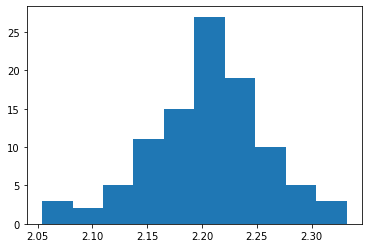

In [35]:
plt.hist(results[:, 0])
plt.show()

In [36]:
import joblib
joblib.dump(results, 'nnet_nocfit_avg.jbl')

['nnet_nocfit_avg.jbl']

In [ ]:
import pandas as pd
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LassoCV, Lasso, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def exp(it):
    print(it)
    df = pd.read_csv(f'rahul/sim_{it}.csv', index_col=0)
    y = df['Y'].values
    X = df[['D'] + [f'X{i}' for i in np.arange(1, 11)]].values
    a_pred = np.zeros(X.shape[0])
    reg_pred = np.zeros(X.shape[0])
    moment_pred = np.zeros(X.shape[0])
    for train, test in KFold(n_splits=5).split(X):
        Xtrain, Xtest, ytrain, ytest = train_test_split(X[train], y[train], test_size=.2, random_state=123)

        torch.cuda.empty_cache()
        Xt = torch.Tensor(Xtrain).to(device)
        Xt_test = torch.Tensor(Xtest).to(device)
        At_test = torch.Tensor(true_reisz(Xtest).reshape(-1, 1)).to(device)

        learner = _get_learner(Xt.shape[1], n_hidden, drop_prob)
        adversary = _get_adversary(Xt.shape[1], n_hidden, drop_prob)
        agmm = AdvReisz(learner, adversary, moment_fn)
        agmm.fit(Xt, Xval=Xt_test, preprocess_epochs=preprocess_epochs,
                earlystop_rounds=earlystop_rounds,
                store_test_every=store_test_every,
                learner_lr=learner_lr, adversary_lr=adversary_lr,
                learner_l2=learner_l2, adversary_l2=adversary_l2,
                n_epochs=n_epochs, bs=bs,
                logger=None, model_dir=str(Path.home()), device=device, verbose=0)
        
        a_pred[test] = agmm.predict(X[test], model='avg')
        est = Pipeline([('p', PolynomialFeatures(degree=1)), ('l', Lasso(alpha=.1))]).fit(X[train], y[train])
        reg_pred[test] = est.predict(X[test])
        moment_pred[test] = moment_fn(X[test], est.predict)

    return mean_ci(moment_pred + a_pred * (y - reg_pred))

true = 2.2

results = np.array([exp(it) for it in np.arange(1, 101).astype(int)])

In [ ]:
results

In [21]:
np.mean((results[:, 1] <= true) & (results[:, 2] >= true))

0.95

In [22]:
np.std(results[:, 0])

0.05583177833641204

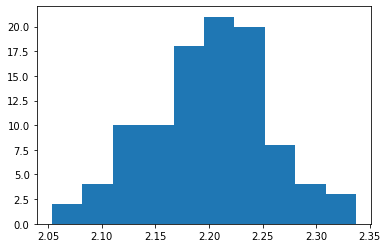

In [23]:
plt.hist(results[:, 0])
plt.show()

In [25]:
import joblib
joblib.dump(results, 'nnet_5fold_avg.jbl')

['nnet_5fold_avg.jbl']

In [3]:
import numpy as np
import pandas as pd
import joblib
import os
true = 2.2
res = {}
plot = False
n_samples_list = [100, 200, 300, 500, 700, 1000, 2000]
start_sample_list = [1, 21, 41, 61, 81]
sample_its = 20
folder = os.path.join('amlt', 'intent-lynx')
for n_samples in n_samples_list:
    res[f'n={n_samples}'] = {}
    for name, var in [('adv_nnet', f'nnet_nocfit_n_{n_samples}'),
                      ('adv_nnet_cfit', f'nnet_5fold_cfit_n_{n_samples}')]:
        results = []
        for start_sample in start_sample_list:
            results += joblib.load(os.path.join(folder, f'nnet_{n_samples}_{start_sample}_{sample_its}',
                                                f'{var}_{start_sample}_{sample_its}.jbl'))
        results = np.array(results)
        if plot:
            plt.hist(results[:, 0])
            plt.title(f'{var}, n={n_samples}')
            plt.show()
        res[f'n={n_samples}'][name] = {
                                 'cov': np.mean((results[:, 1] <= true) & (results[:, 2] >= true)),
                                 'bias': np.mean(results[:, 0] - true),
                                 'rmse': np.sqrt(np.mean((results[:, 0] - true)**2)),
                                 'ci_length': np.mean(results[:, 2] - results[:, 1])}
    res[f'n={n_samples}'] = pd.DataFrame(res[f'n={n_samples}'])

pd.concat(res, axis=0)

adv_nnet  adv_nnet_cfit
n=100  cov        0.190000       0.230000
       bias      -0.309090      -0.321099
       rmse       0.407674       0.416951
       ci_length  0.303624       0.339079
n=200  cov        0.410000       0.350000
       bias      -0.228898      -0.247989
       rmse       0.289952       0.306862
       ci_length  0.343176       0.334302
n=300  cov        0.610000       0.390000
       bias      -0.154567      -0.187084
       rmse       0.205615       0.232386
       ci_length  0.367800       0.303613
n=500  cov        0.670000       0.640000
       bias      -0.113447      -0.124543
       rmse       0.155965       0.168342
       ci_length  0.348523       0.333898
n=700  cov        0.890000       0.820000
       bias      -0.066946      -0.083352
       rmse       0.117675       0.127226
       ci_length  0.355709       0.335406
n=1000 cov        0.870000       0.940000
       bias      -0.034593      -0.043808
       rmse       0.097872       0.092321
       ci_length  0.316622       0.318971
n=2000 cov        0.940000       0.950000
       bias      -0.000152      -0.000196
       rmse       0.056568       0.055668
       ci_length  0.228123       0.232797

In [80]:
import pandas as pd
with pd.option_context('display.float_format', '{:0.2f}'.format):
    print(pd.concat(res, axis=0).loc[['n=100', 'n=500', 'n=1000', 'n=2000']].to_latex(bold_rows=True, multirow=True))

\begin{tabular}{llrr}
\toprule
       &           &  adv\_nnet &  adv\_nnet\_cfit \\
\midrule
\multirow{4}{*}{\textbf{n=100}} & \textbf{cov} &      0.23 &           0.23 \\
       & \textbf{bias} &     -0.31 &          -0.32 \\
       & \textbf{rmse} &      0.41 &           0.41 \\
       & \textbf{ci\_length} &      0.29 &           0.35 \\
\cline{1-4}
\multirow{4}{*}{\textbf{n=500}} & \textbf{cov} &      0.72 &           0.63 \\
       & \textbf{bias} &     -0.11 &          -0.13 \\
       & \textbf{rmse} &      0.15 &           0.17 \\
       & \textbf{ci\_length} &      0.35 &           0.34 \\
\cline{1-4}
\multirow{4}{*}{\textbf{n=1000}} & \textbf{cov} &      0.89 &           0.96 \\
       & \textbf{bias} &     -0.03 &          -0.04 \\
       & \textbf{rmse} &      0.10 &           0.09 \\
       & \textbf{ci\_length} &      0.32 &           0.32 \\
\cline{1-4}
\multirow{4}{*}{\textbf{n=2000}} & \textbf{cov} &      0.96 &           0.96 \\
       & \textbf{bias} &      0.00 &   